# Subspace Inference

Byesisan inference methods are used to generate uncertainty informations in Neural Networks (DNN). However, usingBayesian inference in Deep Neural network is challenging due to large dimension of parameter space. Subspace inference method is used to reduce generate uncertainty information from subspace of DNN paramter space.

Subspace Inference package is implemented based on

Izmailov, P., Maddox, W. J., Kirichenko, P., Garipov, T., Vetrov, D., & Wilson, A. G. (2020, August). Subspace inference for Bayesian deep learning. In Uncertainty in Artificial Intelligence (pp. 1169-1179). PMLR.

### This notebook contains uncertainty generation of simple multilayer perceptron
The is DNN contains 2 inputs and one outputs. The hidden layer sizes are as follows [200 50 50]

Start using subspace inference using in Julia

In [1]:
#use packages
using IJulia
IJulia.installkernel("Julia nodeps", "--depwarn=no")
using NPZ
using Plots
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using Plots
using BSON: @save
using BSON: @load
using Zygote
using Statistics
using SubspaceInference

┌ Info: Installing Julia nodeps kernelspec in C:\Users\manoos\AppData\Roaming\jupyter\kernels\julia-nodeps-1.5
└ @ IJulia C:\Users\manoos\.julia\packages\IJulia\IDNmS\deps\kspec.jl:94
┌ Debug: Initializing CUDA driver
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\src\initialization.jl:89
┌ Debug: Trying to use artifacts...
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:126
┌ Debug: Selecting artifacts based on driver compatibility 11.1.0
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:135
┌ Debug: CUDA toolkit identified as 11.0.3 (providing nvdisasm 11.0.221)
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\discovery.jl:344
┌ Debug: Using CUDA 11.0.3 from an artifact at C:\Users\manoos\.julia\artifacts\796965836d2cdbc7c12c2d896800285d3c266cef
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:176
┌ Debug: Using CUDNN from an artifact at C:\Users\manoos\.julia\artifacts\c68026379752255051652cc354aab4c74bd21dec
└ @ 

### Set root of project folder
This folder contains data and trained networks

In [2]:
root = pwd();
cd(root);

### Plot Data
This loaded data conatains two columns, one is taken as <em>x</em> and <em>y</em>. The <em>x</em>  is converted to features using <em>features</em> function. Then zipped using <em>DataLoader</em> available with <em>Flux</em>

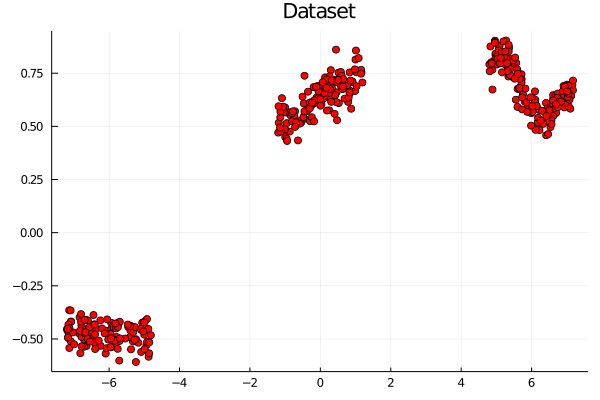

In [3]:
#laod data
data_ld = npzread("data.npy");
x, y = (data_ld[:, 1]', data_ld[:, 2]');
function features(x)
    return vcat(x./2, (x./2).^2)
end

f = features(x);
data =  DataLoader(f,y, batchsize=50, shuffle=true);

#plot data
scatter(data_ld[:,1],data_ld[:,2],color=["red"], title="Dataset", legend=false)

### DNN Model setup
Simple multilayer perceptron is created as using <em>Dense</em> layer. This DNN conatains 2 inputs, 1 output and hidden layers of [200,50,50] size. All layers other than output layer contains ***ReLu*** activation function.

In [4]:
m = Chain(
		Dense(2,200,Flux.relu), 
		Dense(200,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,1),
	)

Chain(Dense(2, 200, relu), Dense(200, 50, relu), Dense(50, 50, relu), Dense(50, 50, relu), Dense(50, 1))

The model is destructed to extract weights and function as below

In [5]:
θ, re = Flux.destructure(m);

### Cost function
Gaussian likelihood cost function is implemented for training as:

In [6]:
L(x, y) = Flux.Losses.mse(m(x), y)/2;

The parameters are load as:

In [7]:
ps = Flux.params(m);

### Optimizer
Optimzer used in this project is Stochastic gradient descent with momentum value:

In [8]:
opt = Momentum(0.01, 0.95);

### Pretrain weights ad save
The DNN needs to pretrains and save for subsce inference as below. NB: training takes little time. This package examppes contain some trained weights.

In [10]:
# epochs = 3000
# for j in 1:5
#    m = Chain(
#            Dense(2,200,Flux.relu),
#            Dense(200,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,1),
#    )
#    ps = Flux.params(m)
#    SubspaceInference.pretrain(epochs, L, ps, data, opt, lr_init =0.01, print_freq= 100)
#    @save "model_weights_$(j).bson" ps
# end

### Plot different SGD solutions

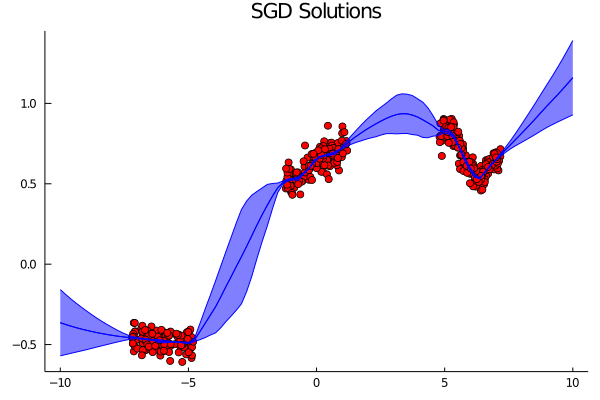

In [11]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,5)
for i in 1:5
	@load "model_weights_$(i).bson" ps
	Flux.loadparams!(m, ps)
	out = m(inp)
	trajectories[:, i] = out'
end
SubspaceInference.plot_predictive(data_ld, trajectories, z, title="SGD Solutions")


### Load pretrained weight
The pretrained weights can be found in examples folder

In [12]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

### Generate uncertainty of weights using
<em>weight_uncertainty</em> function from ***SubspaceInference*** package is used to generate uncertainty of parameter space.

In [13]:
M = 10 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = 100, T=10, M=10)


Traing loss: 0.0008816034751577195 Epoch: 1
Traing loss: 0.0010233978388338905 Epoch: 2
Traing loss: 0.0013585977911323432 Epoch: 3
Traing loss: 0.0011039427515594192 Epoch: 4
Traing loss: 0.0015830161983169243 Epoch: 5
Traing loss: 0.001774420345671972 Epoch: 6
Traing loss: 0.0013925384964895127 Epoch: 7
Traing loss: 0.001860557233524771 Epoch: 8
Traing loss: 0.0016614199055941725 Epoch: 9
Traing loss: 0.0015118905671184812 Epoch: 10


┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference C:\Users\manoos\.julia\packages\Turing\O1Pn0\src\inference\hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\manoos\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:44


15801×100 Array{Float64,2}:
 -0.155376    -0.155385    -0.155374    …  -0.155377    -0.155382
 -0.0865126   -0.0865126   -0.0865123      -0.0865124   -0.0865124
 -0.0614871   -0.0614339   -0.0615423      -0.0614772   -0.0615022
  0.0252926    0.0254985    0.0251918       0.0253917    0.0253071
  0.0484163    0.048418     0.0484157       0.0484173    0.0484166
  0.121013     0.120776     0.121101    …   0.120913     0.120957
  0.14061      0.14065      0.140606        0.140616     0.140638
  0.00952705   0.00993183   0.00944647      0.00966566   0.00971982
  0.116855     0.117089     0.116768        0.116933     0.116928
  0.0216771    0.0218508    0.0216607       0.0217033    0.0218039
 -0.234508    -0.233366    -0.234939    …  -0.234102    -0.234179
  0.123399     0.123374     0.123399        0.123397     0.123378
  0.156879     0.156885     0.156879        0.156881     0.156884
  ⋮                                     ⋱               
  0.159432     0.159226     0.159898        0.1593

### Plot uncertainty using different trajectories that generated using PCA with NUTS

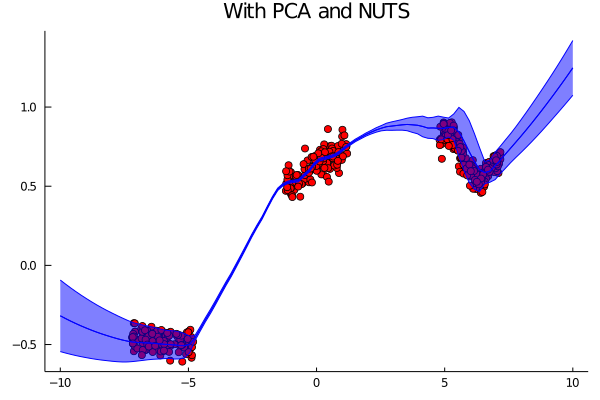

In [14]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end
SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and NUTS")